# Analysis 1

- *Isolate 17 LVs associate to T1D related traits*
- What are these LVs telling us
- *Look at 17 LVs are expressed in RNAseq from Whole blood* 
- Compute 17 daisy anova using LVs from UKbiobank and emerge
- What are these LVs telling us in three group 
- Look at signatures from the three groups within LVs of interest 
- look at the boxplot for top 17 LVs (UK biobank)

## load packages 

In [1]:
library(tidyverse, warn.conflicts=FALSE)
library("ggpubr")
library(reticulate)
library(jsonlite)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘jsonlite’


The following object is masked from ‘package:purrr’:

    flatten




## Prioritizing LVs associated with T1D in both UK Biobank and e-merge

### Importing data: UKBiobank and emerge LV, phenotype traits strings

In [8]:
# Import data
gls_phenomexcan <- readRDS("data/input/gls-summary-phenomexcan.rds")
gls_emerge <- readRDS("data/input/gls-summary-emerge.rds")

# Type 1 diabetes traits in dataset 
UK_biobank_traits <-  c('Type 1 diabetes with ketoacidosis','Type 1 diabetes', 'Non-cancer illness code, self-reported: type 1 diabetes', 'Type 1 diabetes without complications','Type 1 diabetes with ophthalmic complications')
emerge_trait <- 'Type 1 diabetes'

# setting threshold 
threshold <- 0.05

### LVs associated with T1D in phenomexcan and emerge at an FDR adjusted `threshold`

In [9]:
## Phenomexcan
phe_T1D_LVs <- gls_phenomexcan[gls_phenomexcan$phenotype_desc %in% UK_biobank_traits,]
phe_T1D_LVs$new_fdr_UK <- p.adjust(phe_T1D_LVs$pvalue, method = "BH")
phe_T1D_LVs_0.05_fdr <- phe_T1D_LVs[phe_T1D_LVs$new_fdr_UK < threshold,]

## E-merge
e_T1D_LVs <- gls_emerge[gls_emerge$phenotype_desc %in% emerge_trait,]
e_T1D_LVs$new_fdr_e <- p.adjust(e_T1D_LVs$pvalue, method = "BH")
e_T1D_LVs_0.05_fdr <- e_T1D_LVs[e_T1D_LVs$new_fdr_e < threshold,]

## Joining
phe_U_e_fdr_0.05 <- inner_join(phe_T1D_LVs_0.05_fdr,e_T1D_LVs_0.05_fdr, by = "lv")
merged_cohort_T1D <- phe_U_e_fdr_0.05%>%
arrange(lv)%>%
select(c(3,2,4,6,8,9,11))
colnames(merged_cohort_T1D) <- c("LV","UK-Bio-Pheno", "UK-Bio-p-value","UK_Bio_fdr","emerge-pheno","emerge-p-value","emerge-fdr")
merged_cohort_T1D

LV,UK-Bio-Pheno,UK-Bio-p-value,UK_Bio_fdr,emerge-pheno,emerge-p-value,emerge-fdr
<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
LV293,Type 1 diabetes,3.404989e-05,0.0137392187,Type 1 diabetes,1.405687e-04,0.023540275
LV293,Type 1 diabetes without complications,7.722357e-05,0.0254065554,Type 1 diabetes,1.405687e-04,0.023540275
LV45,Type 1 diabetes with ketoacidosis,8.689770e-05,0.0268025084,Type 1 diabetes,2.955102e-04,0.041666938
LV45,Type 1 diabetes,1.889049e-05,0.0093224579,Type 1 diabetes,2.955102e-04,0.041666938
LV45,"Non-cancer illness code, self-reported: type 1 diabetes",1.225965e-06,0.0012100271,Type 1 diabetes,2.955102e-04,0.041666938
LV45,Type 1 diabetes without complications,1.516479e-05,0.0083153581,Type 1 diabetes,2.955102e-04,0.041666938
LV71,Type 1 diabetes with ketoacidosis,5.915115e-05,0.0208507802,Type 1 diabetes,8.541361e-05,0.021075809
LV913,Type 1 diabetes with ketoacidosis,7.235450e-06,0.0044633680,Type 1 diabetes,3.166332e-06,0.001562585
LV913,Type 1 diabetes,6.869573e-06,0.0044633680,Type 1 diabetes,3.166332e-06,0.001562585


## LV's expression in DAISY data grouped by IA progression pattern

### choose time point

In [10]:
tp <- "1"
#tp <- "2" 
#tp <- "diff"

### Importing RNAseq data

In [11]:
DAISY_diff_proj <- readRDS(paste0("output/gp_RNA_proj_",tp,".rds"))
T1D_LV <- as.vector(unique(merged_cohort_T1D$LV))
length(T1D_LV)
T1D_LV

[1] 4

[1] "LV293" "LV45"  "LV71"  "LV913"

### Anova between three T1D progression groups using 4 LVs

In [12]:
res <- data.frame(matrix(nrow = 0, ncol = 6))
# compare between three groups using anova
for (i in 1:length(T1D_LV)){
    comp_i <- compare_means(as.formula(paste0(T1D_LV[i]," ~ Group")),  data = DAISY_diff_proj,
                            method = "anova")
    res <- rbind(res, comp_i)
    }
res_formated <- res[,c(1,2)]
colnames(res_formated) <- c("LV","DAISY_anova_p.val")
res_formated$DAISY_anova_fdr <- p.adjust(res_formated$DAISY_anova_p.val, method = "BH")
res_formated

#saveRDS(res_formated,paste0("output/anova_4-LV_",tp,".rds"))

LV,DAISY_anova_p.val,DAISY_anova_fdr
<chr>,<dbl>,<dbl>
LV293,0.8572262,0.8572262
LV45,0.2500930,0.5001861
LV71,0.1496490,0.5001861
LV913,0.4444621,0.5926162


### Box plot for LVs

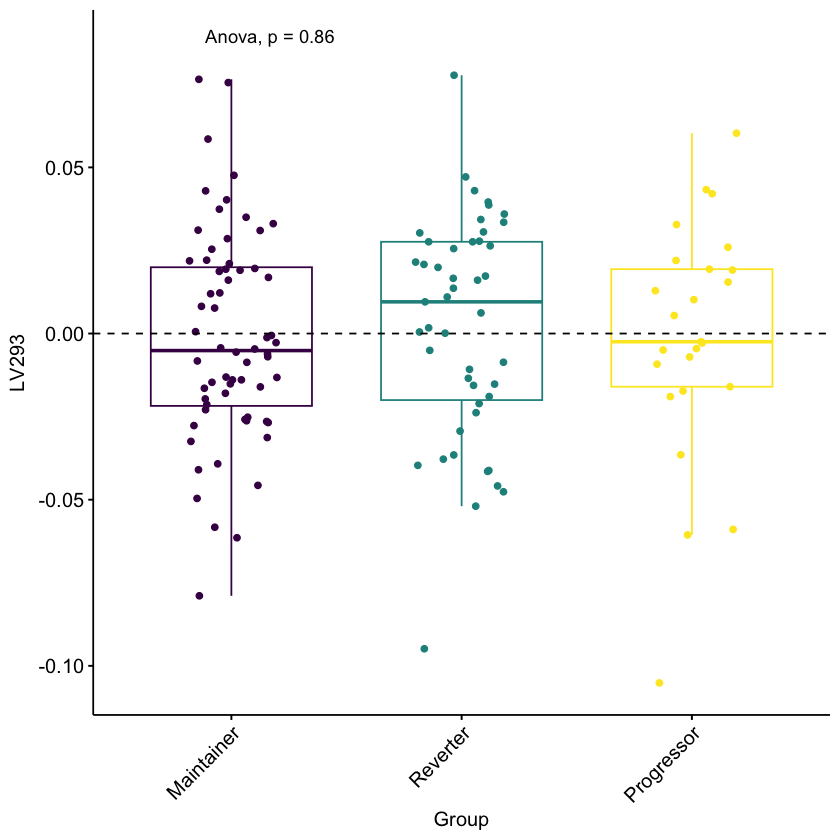

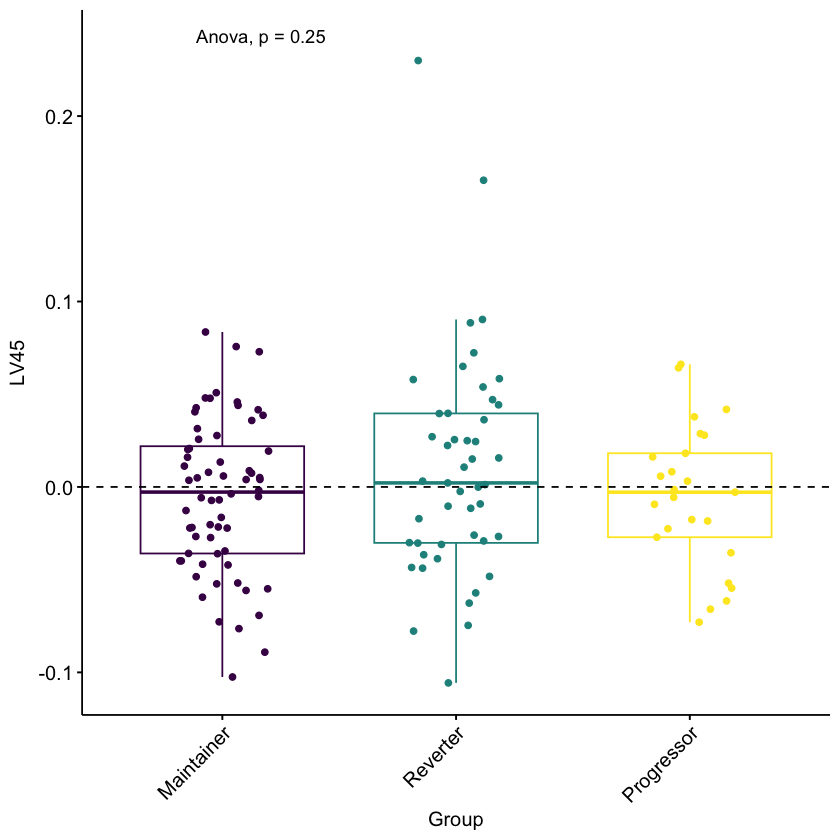

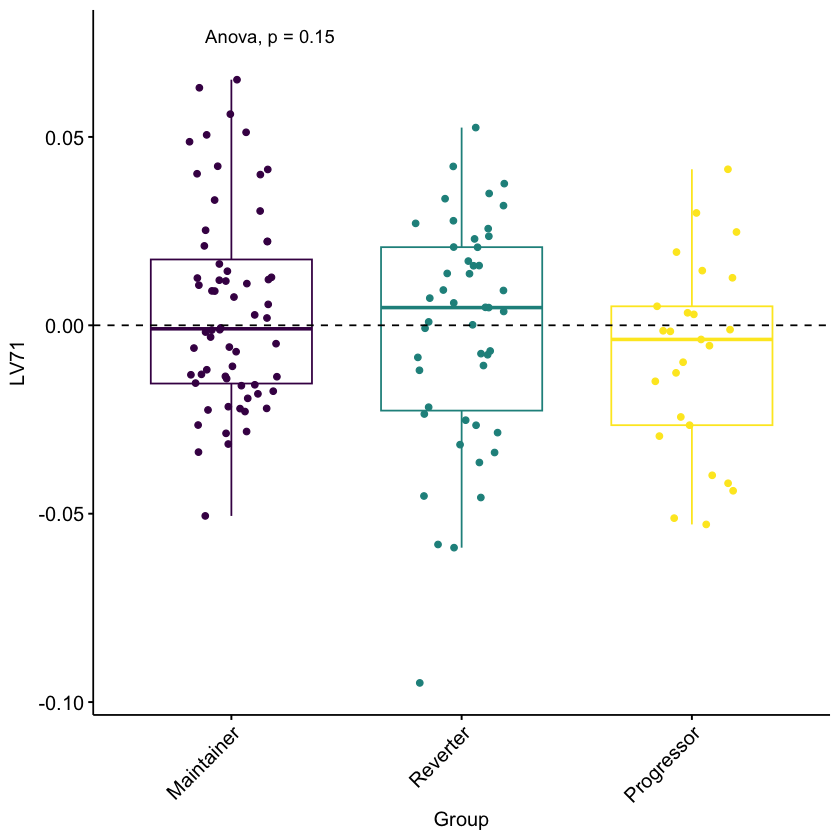

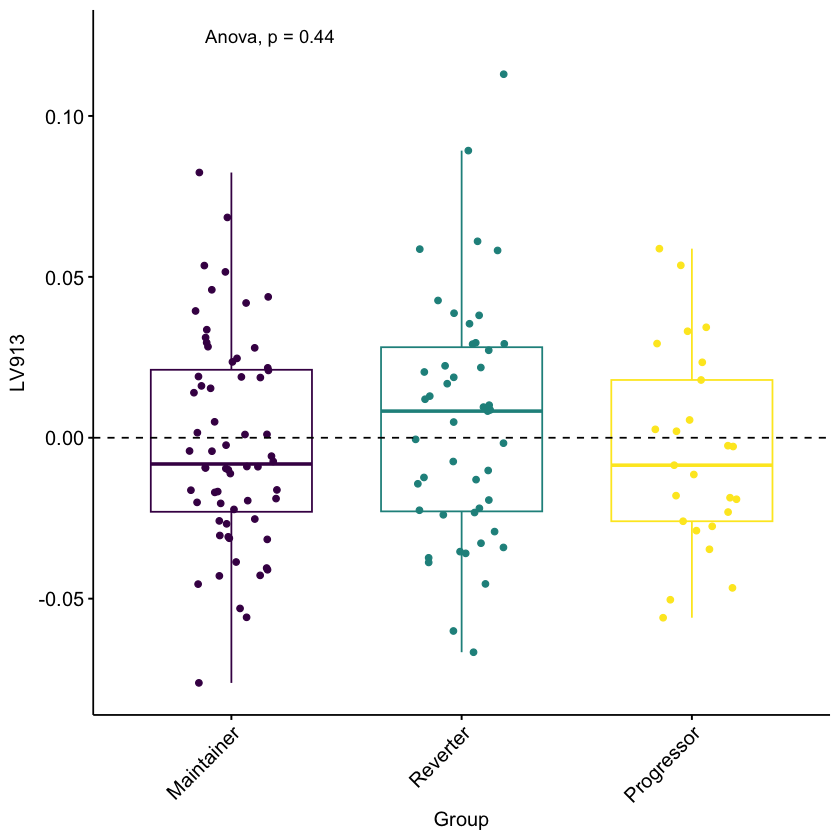

In [13]:
for (i in 1:length(T1D_LV)){
    plot_i <- ggboxplot(DAISY_diff_proj, x = "Group", y = T1D_LV[i], color = "Group", 
          add = "jitter", legend = "none") +
  rotate_x_text(angle = 45)+
  geom_hline(yintercept = mean(DAISY_diff_proj[,T1D_LV[i]]), linetype = 2)+ # Add horizontal line at base mean
  stat_compare_means(method = "anova", label.y = max(DAISY_diff_proj[,T1D_LV[i]])+ 0.01)       # Add global annova p-value 
    print(plot_i)
    
    #ggsave(paste0("LV_",T1D_LV[i],"_visit_",tp,".png"),path = paste0("figures/visit_",tp))
    } 
    #dev.off()

In [8]:
Analysis_1_df <- inner_join(merged_cohort_T1D, res_formated)
dim(Analysis_1_df)
Analysis_1_df

Joining with `by = join_by(LV)`


[1] 11  9

LV,UK-Bio-Pheno,UK-Bio-p-value,UK_Bio_fdr,emerge-pheno,emerge-p-value,emerge-fdr,DAISY_anova_p.val,DAISY_anova_fdr
<chr>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
LV293,Type 1 diabetes,3.404989e-05,0.0137392187,Type 1 diabetes,1.405687e-04,0.023540275,0.70657858,0.7065786
LV293,Type 1 diabetes without complications,7.722357e-05,0.0254065554,Type 1 diabetes,1.405687e-04,0.023540275,0.70657858,0.7065786
LV45,Type 1 diabetes with ketoacidosis,8.689770e-05,0.0268025084,Type 1 diabetes,2.955102e-04,0.041666938,0.07076396,0.2830558
LV45,Type 1 diabetes,1.889049e-05,0.0093224579,Type 1 diabetes,2.955102e-04,0.041666938,0.07076396,0.2830558
LV45,"Non-cancer illness code, self-reported: type 1 diabetes",1.225965e-06,0.0012100271,Type 1 diabetes,2.955102e-04,0.041666938,0.07076396,0.2830558
LV45,Type 1 diabetes without complications,1.516479e-05,0.0083153581,Type 1 diabetes,2.955102e-04,0.041666938,0.07076396,0.2830558
LV71,Type 1 diabetes with ketoacidosis,5.915115e-05,0.0208507802,Type 1 diabetes,8.541361e-05,0.021075809,0.33988821,0.5781957
LV913,Type 1 diabetes with ketoacidosis,7.235450e-06,0.0044633680,Type 1 diabetes,3.166332e-06,0.001562585,0.43364680,0.5781957
LV913,Type 1 diabetes,6.869573e-06,0.0044633680,Type 1 diabetes,3.166332e-06,0.001562585,0.43364680,0.5781957


### Saving output as RDS and CSV

In [ ]:
#saveRDS(analysis_1_df,paste0("output/Analysis_1_Top_17_LVs.rds"))
#write_csv(analysis_1_df,paste0("output/Analysis_1_Top_17_LVs.csv"))

#### UK Biobank Phenotype code description

In [ ]:
pheno_descr_code <- phe_T1D_LVs_nom_0.01 [,c('phenotype','phenotype_desc')]%>%
distinct()

pheno_descr_code